# Machine Learning: Gold Price Prediction

Table of Contents:
- Importing Libraries
- Importing Data
- Data Loading

Feature Expansion
Time-Series Split
Forecasting Horizon
Lagged Features
Machine Learning
Model Creation and Hyperparameter Tuning
Evaluating the Past
Predicting the Future
Feature Importance
Addendum
Conclusions

## Importing libraries

In [100]:
import yfinance as yf
import pandas as pd
pd.options.display.max_columns = 500
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
from stockstats import StockDataFrame 
sns.set_style('ticks')
sns.color_palette("tab10")
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, root_mean_squared_error

## Importing Data

In [101]:
#Importing IAU Gold ETF price
gold = yf.Ticker("IAU").history(period="max")

In [102]:
gold.head(10)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2005-01-28 00:00:00-05:00,8.546,8.546,8.492,8.538,2888500,0.0,0.0,0.0
2005-01-31 00:00:00-05:00,8.446,8.462,8.398,8.454,759500,0.0,0.0,0.0
2005-02-01 00:00:00-05:00,8.422,8.428,8.394,8.424,347500,0.0,0.0,0.0
2005-02-02 00:00:00-05:00,8.446,8.446,8.408,8.446,1496500,0.0,0.0,0.0
2005-02-03 00:00:00-05:00,8.316,8.348,8.302,8.344,534000,0.0,0.0,0.0
2005-02-04 00:00:00-05:00,8.320,8.332,8.284,8.300,433500,0.0,0.0,0.0
2005-02-07 00:00:00-05:00,8.314,8.314,8.250,8.270,938000,0.0,0.0,0.0
2005-02-08 00:00:00-05:00,8.256,8.282,8.218,8.258,880500,0.0,0.0,0.0
2005-02-09 00:00:00-05:00,8.218,8.272,8.208,8.268,404500,0.0,0.0,0.0


Since this gold comes from the `yfinance` library, it does not require any additional cleaning or formatting.

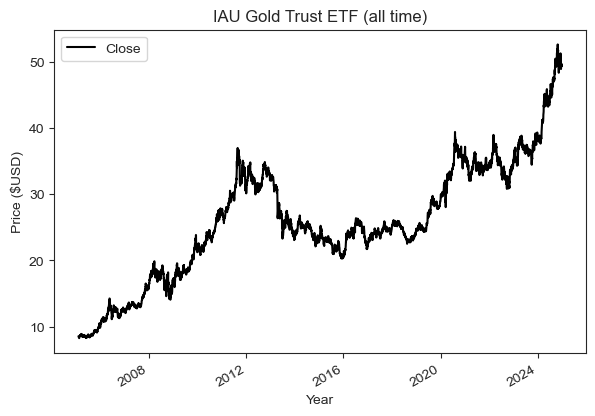

In [103]:
#Plotting close price history
gold.plot.line(y="Close", use_index=True, color='k')
plt.title("IAU Gold Trust ETF (all time)")
plt.tight_layout(pad=3)
plt.xlabel("Year")
plt.ylabel("Price ($USD)")
plt.savefig("images/GoldETF_All_Time.png", bbox_inches='tight')
plt.show()

In [104]:
#Removing unnecessary Dividends and Stock Splits columns
del gold["Dividends"]
del gold["Stock Splits"]

In [105]:
#Adding Next Week's price column
gold["Next week"] = gold["Close"].shift(-7)

The chart of our interest here is going to be the weekly chart. Our goal is to predict whether the price rises or falls next week, not necessarily it's exact value in the next week.

In [106]:
#Adding target column; 1 for price rise, 0 else
gold["Weekly Target"] = (gold["Next week"] > gold["Close"]).astype(int)

In [107]:
gold.head(4)

,Open,High,Low,Close,Volume,Capital Gains,Next week,Weekly Target
Date,,,,,,,,
2005-01-28 00:00:00-05:00,8.546,8.546,8.492,8.538,2888500,0.0,8.258,0
2005-01-31 00:00:00-05:00,8.446,8.462,8.398,8.454,759500,0.0,8.268,0
2005-02-01 00:00:00-05:00,8.422,8.428,8.394,8.424,347500,0.0,8.362,0
2005-02-02 00:00:00-05:00,8.446,8.446,8.408,8.446,1496500,0.0,8.424,0


In [108]:
gold.tail(1)

,Open,High,Low,Close,Volume,Capital Gains,Next week,Weekly Target
Date,,,,,,,,
2024-12-27 00:00:00-05:00,49.360001,49.490002,49.299999,49.369999,2654200,0.0,NaN,0


It is well known that major market shifts (e.g. Black Swan events, financial crises, etc.) affect how our learning algorithm trains itself. In this project, we will pureposefully leave the 2008 financial crisis gold inside the training set. This is because gold is a relatively volatile instrument anyways, and its markets usually respond to unforseen geopolitical (or other) events.

## Time-Series Split

Before doing a Time Series Split, we will split the data into the main train/test sets. Our test set is going to subsist of approximately the last 4 years of data, while the rest goes into the training set.

In [109]:
#Splitting data into two main train/test sets
gold_train = gold.loc[:"2020-01-01"].sort_values(by="Date")
gold_test =  gold.loc["2020-01-01":].sort_values(by="Date")

In [110]:
gold_train

,Open,High,Low,Close,Volume,Capital Gains,Next week,Weekly Target
Date,,,,,,,,
2005-01-28 00:00:00-05:00,8.546000,8.546,8.492000,8.538000,2888500,0.0,8.258000,0
2005-01-31 00:00:00-05:00,8.446000,8.462,8.398000,8.454000,759500,0.0,8.268000,0
2005-02-01 00:00:00-05:00,8.422000,8.428,8.394000,8.424000,347500,0.0,8.362000,0
2005-02-02 00:00:00-05:00,8.446000,8.446,8.408000,8.446000,1496500,0.0,8.424000,0
2005-02-03 00:00:00-05:00,8.316000,8.348,8.302000,8.344000,534000,0.0,8.524000,1
...,...,...,...,...,...,...,...,...
2019-12-24 00:00:00-05:00,28.500000,28.680,28.500000,28.660000,2714500,0.0,29.920000,1
2019-12-26 00:00:00-05:00,28.820000,28.920,28.799999,28.900000,3568150,0.0,30.040001,1
2019-12-27 00:00:00-05:00,28.879999,28.980,28.860001,28.879999,3541550,0.0,29.820000,1


In [111]:
#Initializing a TimeSeriesSplit generator for time-series cross-validation
time_ser_split = TimeSeriesSplit(n_splits=12, test_size=250, gap=0)
#Defining predictors
predictors = ['Open', 'High', 'Low', 'Close', 'Volume']

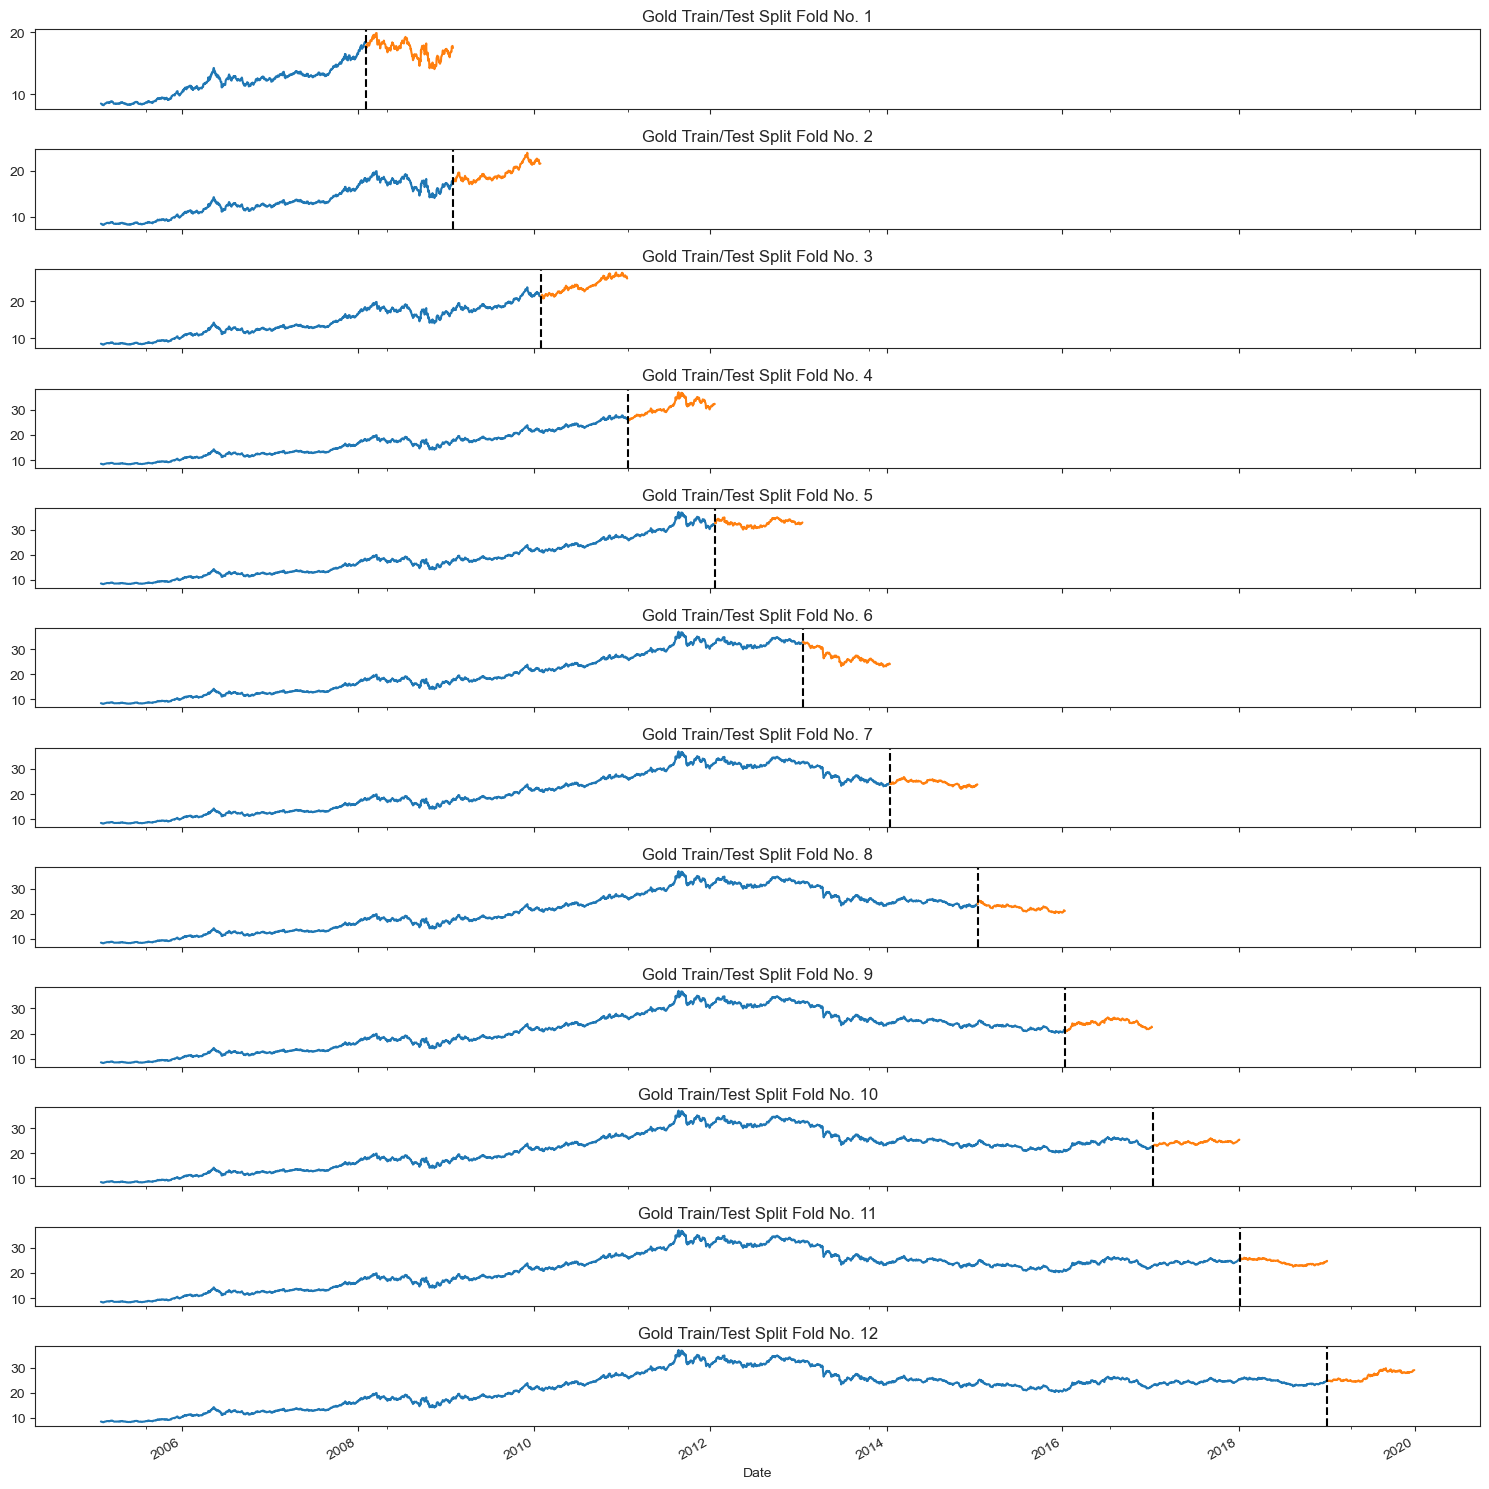

In [112]:
#Visualizing the time-series split
fig, ax = plt.subplots(12, 1, figsize=(15,15), sharex=True)

fold = 0
for train_index, test_index in time_ser_split.split(gold_train):
    train = gold_train.iloc[train_index]
    test = gold_train.iloc[test_index]
    train['Close'].plot(ax=ax[fold], label='Training Set', title=f'Gold Train/Test Split Fold No. {fold+1}')
    test['Close'].plot(ax=ax[fold], label='Test Set')
    ax[fold].axvline(test.index.min(), color='k', ls='--')
    fold += 1

plt.tight_layout()
plt.savefig('images/01_TimeSeriesSplit.png', bbox_inches='tight')
plt.show()

## Basic Machine Learning Model

In [113]:
#Building an initial Machine Learning Model
model = RandomForestClassifier(n_estimators=1000, min_samples_split=100, random_state=57)
results = cross_val_score(model, gold_train[predictors], gold_train["Weekly Target"], cv = time_ser_split)

In [114]:
#Score of basic model
print(f"Score of basic model: {(results).mean()}")

Score of basic model: 0.4736666666666667


In [115]:
#RMSE of basic model (this unfortunately requires fitting the model again)
model.fit(gold_train[predictors], gold_train["Weekly Target"])
RMSE_ = root_mean_squared_error(gold_test["Weekly Target"], model.predict(gold_test[predictors]))
print(f"RMSE of basic model: {RMSE_}\nMean of basic model: {gold_test["Weekly Target"].mean()}")

RMSE of basic model: 0.7025884807256718
Mean of basic model: 0.552547770700637


A score of 0.47 is not very good. Additionally, the RMSE is not only the same order of magnitude, but larger than the mean, which is indicative of a poor model. We would be better of going against the model when making predictions about price. Let us develop the model some more by adding more predicting features.

## Feature Expansion

### Lagged Features

In [116]:
target_map = gold['Weekly Target'].to_dict()

In [117]:
def add_lag_features(data, predictors):
    data['lag1'] = (data.index-pd.Timedelta('364 days')).map(target_map)
    data['lag2'] = (data.index-pd.Timedelta('798 days')).map(target_map)
    data['lag3'] = (data.index-pd.Timedelta('1092 days')).map(target_map)
    predictors += (['lag1', 'lag2', 'lag3'])
    return data

In [118]:
add_lag_features(gold_train, predictors)

,Open,High,Low,Close,Volume,Capital Gains,Next week,Weekly Target,lag1,lag2,lag3
Date,,,,,,,,,,,
2005-01-28 00:00:00-05:00,8.546000,8.546,8.492000,8.538000,2888500,0.0,8.258000,0,NaN,NaN,NaN
2005-01-31 00:00:00-05:00,8.446000,8.462,8.398000,8.454000,759500,0.0,8.268000,0,NaN,NaN,NaN
2005-02-01 00:00:00-05:00,8.422000,8.428,8.394000,8.424000,347500,0.0,8.362000,0,NaN,NaN,NaN
2005-02-02 00:00:00-05:00,8.446000,8.446,8.408000,8.446000,1496500,0.0,8.424000,0,NaN,NaN,NaN
2005-02-03 00:00:00-05:00,8.316000,8.348,8.302000,8.344000,534000,0.0,8.524000,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24 00:00:00-05:00,28.500000,28.680,28.500000,28.660000,2714500,0.0,29.920000,1,NaN,NaN,1.0
2019-12-26 00:00:00-05:00,28.820000,28.920,28.799999,28.900000,3568150,0.0,30.040001,1,1.0,NaN,1.0
2019-12-27 00:00:00-05:00,28.879999,28.980,28.860001,28.879999,3541550,0.0,29.820000,1,1.0,NaN,1.0


In [119]:
#Number of NaN values in lag2 column
gold_train["lag2"].isna().sum()

1818

KEEEP IN MIND THAT HERE WE ARE PREDICTING UP OR DOWN, NOOT PRICEE!!!! THAT'S WHY FEATURES ARE THE WAY THEY ARE

### SMA (50 and 200 Day)

In [120]:
def create_SMA(data, predictors):
    data["SMA50"] = data.rolling(window=50).mean()["Weekly Target"]
    data["SMA200"] = data.rolling(window=200).mean()["Weekly Target"]
    predictors += ["SMA50", "SMA200"]
    return data

In [121]:
create_SMA(gold_train, predictors)

,Open,High,Low,Close,Volume,Capital Gains,Next week,Weekly Target,lag1,lag2,lag3,SMA50,SMA200
Date,,,,,,,,,,,,,
2005-01-28 00:00:00-05:00,8.546000,8.546,8.492000,8.538000,2888500,0.0,8.258000,0,NaN,NaN,NaN,NaN,NaN
2005-01-31 00:00:00-05:00,8.446000,8.462,8.398000,8.454000,759500,0.0,8.268000,0,NaN,NaN,NaN,NaN,NaN
2005-02-01 00:00:00-05:00,8.422000,8.428,8.394000,8.424000,347500,0.0,8.362000,0,NaN,NaN,NaN,NaN,NaN
2005-02-02 00:00:00-05:00,8.446000,8.446,8.408000,8.446000,1496500,0.0,8.424000,0,NaN,NaN,NaN,NaN,NaN
2005-02-03 00:00:00-05:00,8.316000,8.348,8.302000,8.344000,534000,0.0,8.524000,1,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24 00:00:00-05:00,28.500000,28.680,28.500000,28.660000,2714500,0.0,29.920000,1,NaN,NaN,1.0,0.62,0.6
2019-12-26 00:00:00-05:00,28.820000,28.920,28.799999,28.900000,3568150,0.0,30.040001,1,1.0,NaN,1.0,0.62,0.6
2019-12-27 00:00:00-05:00,28.879999,28.980,28.860001,28.879999,3541550,0.0,29.820000,1,1.0,NaN,1.0,0.62,0.6


### EMA (50 and 200 Day)

In [122]:
def create_EMA(data, predictors):
    data["EMA50"] = data.ewm(span=50).mean()["Weekly Target"]
    data["EMA200"] = data.ewm(span=200).mean()["Weekly Target"]
    predictors += ["EMA50", "EMA200"]
    return data

In [123]:
create_EMA(gold_train, predictors)

,Open,High,Low,Close,Volume,Capital Gains,Next week,Weekly Target,lag1,lag2,lag3,SMA50,SMA200,EMA50,EMA200
Date,,,,,,,,,,,,,,,
2005-01-28 00:00:00-05:00,8.546000,8.546,8.492000,8.538000,2888500,0.0,8.258000,0,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
2005-01-31 00:00:00-05:00,8.446000,8.462,8.398000,8.454000,759500,0.0,8.268000,0,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
2005-02-01 00:00:00-05:00,8.422000,8.428,8.394000,8.424000,347500,0.0,8.362000,0,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
2005-02-02 00:00:00-05:00,8.446000,8.446,8.408000,8.446000,1496500,0.0,8.424000,0,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
2005-02-03 00:00:00-05:00,8.316000,8.348,8.302000,8.344000,534000,0.0,8.524000,1,NaN,NaN,NaN,NaN,NaN,0.216313,0.204020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24 00:00:00-05:00,28.500000,28.680,28.500000,28.660000,2714500,0.0,29.920000,1,NaN,NaN,1.0,0.62,0.6,0.713699,0.607250
2019-12-26 00:00:00-05:00,28.820000,28.920,28.799999,28.900000,3568150,0.0,30.040001,1,1.0,NaN,1.0,0.62,0.6,0.724927,0.611158
2019-12-27 00:00:00-05:00,28.879999,28.980,28.860001,28.879999,3541550,0.0,29.820000,1,1.0,NaN,1.0,0.62,0.6,0.735714,0.615027


### S&P 500 and Crude Oil Futures Price Data

We introduce the S&P 500 ETF as another input feature of our classifier. It is commonly thought (and observed) that the value of this index is inversely proportional to the price of gold. We also include the Crude Oil Futures price data, as oil can be a good indicator for the state of the market.

In [124]:
def add_sp500_data(data, start, end, predictors):
    snp = yf.Ticker("^GSPC").history(start=start, end=end)
    data["S&P500 Close"] = snp["Close"].copy()
    del snp
    predictors += ["S&P500 Close"]
    return data

def add_CLF_data(data, start, end, predictors):
    CLF = yf.Ticker("CL=F").history(start=start, end=end)
    data["CLF Close"] = CLF["Close"].copy()
    del CLF
    predictors += ["CLF Close"]
    return data

In [125]:
add_sp500_data(gold_train, gold_train.index[0], gold_train.index[-1], predictors)
add_CLF_data(gold_train, gold_train.index[0], gold_train.index[-1], predictors)

,Open,High,Low,Close,Volume,Capital Gains,Next week,Weekly Target,lag1,lag2,lag3,SMA50,SMA200,EMA50,EMA200,S&P500 Close,CLF Close
Date,,,,,,,,,,,,,,,,,
2005-01-28 00:00:00-05:00,8.546000,8.546,8.492000,8.538000,2888500,0.0,8.258000,0,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1171.359985,47.180000
2005-01-31 00:00:00-05:00,8.446000,8.462,8.398000,8.454000,759500,0.0,8.268000,0,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1181.270020,48.200001
2005-02-01 00:00:00-05:00,8.422000,8.428,8.394000,8.424000,347500,0.0,8.362000,0,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1189.410034,47.119999
2005-02-02 00:00:00-05:00,8.446000,8.446,8.408000,8.446000,1496500,0.0,8.424000,0,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1193.189941,46.689999
2005-02-03 00:00:00-05:00,8.316000,8.348,8.302000,8.344000,534000,0.0,8.524000,1,NaN,NaN,NaN,NaN,NaN,0.216313,0.204020,1189.890015,46.450001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24 00:00:00-05:00,28.500000,28.680,28.500000,28.660000,2714500,0.0,29.920000,1,NaN,NaN,1.0,0.62,0.6,0.713699,0.607250,3223.379883,61.110001
2019-12-26 00:00:00-05:00,28.820000,28.920,28.799999,28.900000,3568150,0.0,30.040001,1,1.0,NaN,1.0,0.62,0.6,0.724927,0.611158,3239.909912,61.680000
2019-12-27 00:00:00-05:00,28.879999,28.980,28.860001,28.879999,3541550,0.0,29.820000,1,1.0,NaN,1.0,0.62,0.6,0.735714,0.615027,3240.020020,61.720001


### RSI (14 Day)

In [127]:
def get_RSI(data):
    stock = StockDataFrame.retype(data)
    rsi = stock.get('rsi_14')
    data["RSI_14"] = rsi
    return data

In [128]:
get_RSI(gold_train)

,open,high,low,close,volume,Capital Gains,Next week,Weekly Target,lag1,lag2,lag3,SMA50,SMA200,EMA50,EMA200,S&P500 Close,CLF Close,RSI_14
Date,,,,,,,,,,,,,,,,,,
2005-01-28 00:00:00-05:00,8.546000,8.546,8.492000,8.538000,2888500,0.0,8.258000,0,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1171.359985,47.180000,NaN
2005-01-31 00:00:00-05:00,8.446000,8.462,8.398000,8.454000,759500,0.0,8.268000,0,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1181.270020,48.200001,0.000000
2005-02-01 00:00:00-05:00,8.422000,8.428,8.394000,8.424000,347500,0.0,8.362000,0,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1189.410034,47.119999,0.000000
2005-02-02 00:00:00-05:00,8.446000,8.446,8.408000,8.446000,1496500,0.0,8.424000,0,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1193.189941,46.689999,17.990817
2005-02-03 00:00:00-05:00,8.316000,8.348,8.302000,8.344000,534000,0.0,8.524000,1,NaN,NaN,NaN,NaN,NaN,0.216313,0.204020,1189.890015,46.450001,9.477470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24 00:00:00-05:00,28.500000,28.680,28.500000,28.660000,2714500,0.0,29.920000,1,NaN,NaN,1.0,0.62,0.6,0.713699,0.607250,3223.379883,61.110001,65.054440
2019-12-26 00:00:00-05:00,28.820000,28.920,28.799999,28.900000,3568150,0.0,30.040001,1,1.0,NaN,1.0,0.62,0.6,0.724927,0.611158,3239.909912,61.680000,69.978275
2019-12-27 00:00:00-05:00,28.879999,28.980,28.860001,28.879999,3541550,0.0,29.820000,1,1.0,NaN,1.0,0.62,0.6,0.735714,0.615027,3240.020020,61.720001,69.104436


There is no point in calulating the MACD indicator, since it is a function of two different EMAs - it is therefore redundant. Calculating two different SMAs and EMAs might have been a redundancy in itself that only does harm to the model. Later on, while testing the model, we might remove one of them from the list of predictors.

In [132]:
gold_train.head(5)

,open,high,low,close,volume,Capital Gains,Next week,Weekly Target,lag1,lag2,lag3,SMA50,SMA200,EMA50,EMA200,S&P500 Close,CLF Close,RSI_14
Date,,,,,,,,,,,,,,,,,,
2005-01-28 00:00:00-05:00,8.546,8.546,8.492,8.538,2888500,0.0,8.258,0,NaN,NaN,NaN,NaN,NaN,0.000000,0.00000,1171.359985,47.180000,NaN
2005-01-31 00:00:00-05:00,8.446,8.462,8.398,8.454,759500,0.0,8.268,0,NaN,NaN,NaN,NaN,NaN,0.000000,0.00000,1181.270020,48.200001,0.000000
2005-02-01 00:00:00-05:00,8.422,8.428,8.394,8.424,347500,0.0,8.362,0,NaN,NaN,NaN,NaN,NaN,0.000000,0.00000,1189.410034,47.119999,0.000000
2005-02-02 00:00:00-05:00,8.446,8.446,8.408,8.446,1496500,0.0,8.424,0,NaN,NaN,NaN,NaN,NaN,0.000000,0.00000,1193.189941,46.689999,17.990817
2005-02-03 00:00:00-05:00,8.316,8.348,8.302,8.344,534000,0.0,8.524,1,NaN,NaN,NaN,NaN,NaN,0.216313,0.20402,1189.890015,46.450001,9.477470


## More Advanced Model

In [144]:
gold_train.rename(columns={"open":"Open", "high":"High", "low":"Low", "close":"Close", "volume":"Volume"}, inplace=True)

In [147]:
#Building an initial Machine Learning Model
model2 = RandomForestClassifier(n_estimators=1000, min_samples_split=100, random_state=57)
results2 = cross_val_score(model2, gold_train[predictors], gold_train["Weekly Target"], cv = time_ser_split)

In [148]:
#Score of more advanced model
print(f"Score of basic model: {(results2).mean()}")

Score of basic model: 0.5843333333333333


At this point it needs to be pondered which predictors are available in the test set, because the test set will represent the prices in a future point in time. Only the lagging indicators will be available then.

In [151]:
gold_train

,Open,High,Low,Close,Volume,Capital Gains,Next week,Weekly Target,lag1,lag2,lag3,SMA50,SMA200,EMA50,EMA200,S&P500 Close,CLF Close,RSI_14
Date,,,,,,,,,,,,,,,,,,
2005-01-28 00:00:00-05:00,8.546000,8.546,8.492000,8.538000,2888500,0.0,8.258000,0,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1171.359985,47.180000,NaN
2005-01-31 00:00:00-05:00,8.446000,8.462,8.398000,8.454000,759500,0.0,8.268000,0,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1181.270020,48.200001,0.000000
2005-02-01 00:00:00-05:00,8.422000,8.428,8.394000,8.424000,347500,0.0,8.362000,0,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1189.410034,47.119999,0.000000
2005-02-02 00:00:00-05:00,8.446000,8.446,8.408000,8.446000,1496500,0.0,8.424000,0,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1193.189941,46.689999,17.990817
2005-02-03 00:00:00-05:00,8.316000,8.348,8.302000,8.344000,534000,0.0,8.524000,1,NaN,NaN,NaN,NaN,NaN,0.216313,0.204020,1189.890015,46.450001,9.477470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24 00:00:00-05:00,28.500000,28.680,28.500000,28.660000,2714500,0.0,29.920000,1,NaN,NaN,1.0,0.62,0.6,0.713699,0.607250,3223.379883,61.110001,65.054440
2019-12-26 00:00:00-05:00,28.820000,28.920,28.799999,28.900000,3568150,0.0,30.040001,1,1.0,NaN,1.0,0.62,0.6,0.724927,0.611158,3239.909912,61.680000,69.978275
2019-12-27 00:00:00-05:00,28.879999,28.980,28.860001,28.879999,3541550,0.0,29.820000,1,1.0,NaN,1.0,0.62,0.6,0.735714,0.615027,3240.020020,61.720001,69.104436


In [ ]:
#RMSE of more advanced model (this unfortunately requires fitting the model again)
model2.fit(gold_train[predictors], gold_train["Weekly Target"])
RMSE_ = root_mean_squared_error(gold_test["Weekly Target"], model.predict(gold_test[predictors]))
print(f"RMSE of basic model: {RMSE_}\nMean of basic model: {gold_test["Weekly Target"].mean()}")

In [130]:
preds = model.predict(test[predictors])

KeyError: "['lag1', 'lag2', 'lag3', 'SMA50', 'SMA200', 'EMA50', 'EMA200', 'S&P500 Close', 'CLF Close'] not in index"

In [98]:
preds = pd.Series(preds, index=test.index)

In [99]:
precision_score(test["Target"], preds)

0.6060606060606061

<Axes: xlabel='Date'>

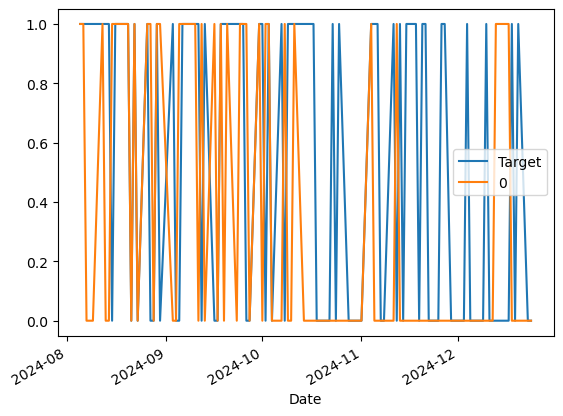

In [100]:
results = pd.concat([test["Target"], preds], axis=1)
results.plot()

In [101]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    results = pd.concat([test["Target"], preds], axis=1)
    return results

In [102]:
def backtest(gold, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, gold.shape[0], step):
        train = gold.iloc[0:i].copy()
        test = gold.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

In [103]:
predictions = backtest(gold, model, predictors)

In [104]:
predictions

,Target,Predictions
Date,,
2020-10-13 00:00:00-04:00,0,0
2020-10-14 00:00:00-04:00,0,0
2020-10-15 00:00:00-04:00,0,0
2020-10-16 00:00:00-04:00,1,0
2020-10-19 00:00:00-04:00,1,0
...,...,...
2024-12-18 00:00:00-05:00,1,1
2024-12-19 00:00:00-05:00,0,0
2024-12-20 00:00:00-05:00,1,0


In [105]:
predictions["Predictions"].value_counts()

Predictions
0    842
1    215
Name: count, dtype: int64

In [106]:
#Our Model's precision
precision_score(predictions["Target"], predictions["Predictions"])

0.5581395348837209

In [107]:
#Percentage of days the price went up or down
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.513718
0    0.486282
Name: count, dtype: float64

It turns out that following our simple model outperforms buying or selling according to the documented percentage of days that the price went up or down. This is good.

## Feature Expansion

In [108]:
#Defining different forecasting horizons
horizons = [2, 50, 60, 250, 1000]
new_predictors = []

for horizon in horizons:
    moving_average = gold.rolling(horizon).mean()
    ratio_column = f"Close_Ratio_{horizon}"
    gold[ratio_column] = gold["Close"] / moving_average["Close"]

    trend_column = f"Trend_{horizon}"
    gold[trend_column] = gold.shift(-1).rolling(horizon).sum()["Target"]

    new_predictors += [ratio_column, trend_column]

In [109]:
gold.dropna(inplace=True)
gold.head(10)

,Open,High,Low,Close,Volume,Capital Gains,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_50,Trend_50,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,,
2014-10-27 00:00:00-04:00,16.995354,17.038970,16.762740,16.835432,45150,0.0,17.242502,1,0.992288,1.0,0.862043,20.0,0.848238,27.0,0.771111,117.0,0.460191,452.0
2014-10-28 00:00:00-04:00,16.908120,17.271580,16.777275,17.242502,61900,0.0,16.980814,0,1.011945,0.0,0.887313,20.0,0.871728,26.0,0.790305,117.0,0.472022,452.0
2014-10-29 00:00:00-04:00,17.373349,17.373349,16.864507,16.980814,83650,0.0,16.762735,0,0.992354,0.0,0.878380,20.0,0.861484,26.0,0.778909,116.0,0.465660,451.0
2014-10-30 00:00:00-04:00,16.893581,16.980812,16.719121,16.762735,50900,0.0,16.719124,0,0.993537,0.0,0.871688,19.0,0.853663,25.0,0.769474,116.0,0.460443,450.0
2014-10-31 00:00:00-04:00,16.849969,16.864508,16.646432,16.719124,75600,0.0,16.588276,0,0.998697,0.0,0.873807,18.0,0.854521,24.0,0.768048,115.0,0.460024,450.0
2014-11-03 00:00:00-05:00,16.733660,16.806352,16.428354,16.588276,96350,0.0,16.253895,0,0.996072,1.0,0.871631,18.0,0.851207,24.0,0.762608,116.0,0.457210,451.0
2014-11-04 00:00:00-05:00,16.428355,16.515584,16.224817,16.253895,66900,0.0,16.704582,1,0.989819,2.0,0.859048,19.0,0.837673,24.0,0.747845,116.0,0.448729,452.0
2014-11-05 00:00:00-05:00,16.210278,16.762736,16.108509,16.704582,113200,0.0,16.791817,1,1.013674,2.0,0.887670,19.0,0.864375,24.0,0.769098,117.0,0.461908,452.0
2014-11-06 00:00:00-05:00,16.704586,16.849970,16.617356,16.791817,116400,0.0,19.030724,1,1.002604,2.0,0.897004,19.0,0.872620,25.0,0.773645,118.0,0.464992,452.0


In [118]:
model = RandomForestClassifier(n_estimators=1000, min_samples_split=50, random_state=57)

In [111]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >= .6] = 1
    preds[preds < .6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    results = pd.concat([test["Target"], preds], axis=1)
    return results

In [112]:
predictions = backtest(gold, model, new_predictors)

In [113]:
predictions["Predictions"].value_counts()

Predictions
0.0    44
1.0    13
Name: count, dtype: int64

In [114]:
precision_score(predictions["Target"], predictions["Predictions"])

1.0

In [115]:
predictions

,Target,Predictions
Date,,
2024-10-03 00:00:00-04:00,1,0.0
2024-10-04 00:00:00-04:00,0,0.0
2024-10-07 00:00:00-04:00,1,0.0
2024-10-08 00:00:00-04:00,0,0.0
2024-10-09 00:00:00-04:00,1,1.0
2024-10-10 00:00:00-04:00,1,1.0
2024-10-11 00:00:00-04:00,1,1.0
2024-10-14 00:00:00-04:00,1,1.0
2024-10-15 00:00:00-04:00,1,1.0


In [116]:
#other input features: other indices across the world that trade in earlier hours than gold
#                       news, key stocks in the index, resolution increase (hours, minutes, ticks)

In [227]:
#Inputs: Close+, RSI+, MACD-, Volume+, SMA+, EMA+, CL+, možda GAS, S&P500+, RETAIL SENTIMENT
# feed in 10 days of previous gold